In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, OneHotEncoder
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer



In [24]:
data = pd.read_csv(r'data/Student data (1).csv')

df  = pd.DataFrame(data)

#get the column names
features = df.iloc[1:15,0].to_list()
target = df.iloc[17:18, 0].to_list()
columns = features+target
cleaned_columns = [col.replace(" numeric", "").replace("'", "").strip() for col in columns]

#slice dataset to start with the correct data
df = df.iloc[23:,]
df.columns = cleaned_columns
df=df.reset_index(drop = True)
df

,First Term Gpa,Second Term Gpa,First Language,Funding,School,FastTrack,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,"FirstYearPersistence {1,0}"
0,0,0,1,2.0,6.0,2.0,1.0,1.0,2.0,1,1,59,16,7,1.0
1,2.5,2,3,4.0,6.0,1.0,2.0,2.0,2.0,1,3,?,?,7,1.0
2,4.25,3.923077,1,1.0,6.0,2.0,1.0,1.0,1.0,2,3,92,41,9,1.0
3,3.020833,2.321429,3,4.0,6.0,1.0,2.0,2.0,2.0,2,3,?,?,8,1.0
4,4.275,4.326923,1,2.0,6.0,1.0,1.0,1.0,1.0,2,3,97,?,9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,1.413043,0,?,4.0,6.0,2.0,2.0,2.0,2.0,1,1,?,47,10,0.0
1433,4.36,4.074074,1,2.0,6.0,1.0,1.0,1.0,1.0,2,4,?,?,10,1.0
1434,2.020833,2.45,1,2.0,6.0,2.0,1.0,1.0,2.0,1,1,78,18,9,1.0
1435,4.021739,4.357143,?,4.0,6.0,2.0,1.0,2.0,1.0,1,2,?,46,8,1.0


In [25]:
#Replace ? with NaN

df.replace("?", np.NaN, inplace= True)

In [26]:
df_cleaning = df.copy()

## Inital EDA

### Inital data shape

In [27]:
print(f' The Dataset has {df.shape[0]} instances and {df.shape[1]} columns')

 The Dataset has 1437 instances and 15 columns


In [28]:
df.describe()

,Funding,School,FastTrack,Coop,Residency,Gender,"FirstYearPersistence {1,0}"
count,1437.000000,1437.0,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
mean,2.926931,6.0,1.741823,1.695198,1.406402,1.774530,0.791928
std,1.257658,0.0,0.437784,0.460484,0.491332,0.419699,0.406070
min,1.000000,6.0,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,6.0,1.000000,1.000000,1.000000,2.000000,1.000000
50%,2.000000,6.0,2.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,6.0,2.000000,2.000000,2.000000,2.000000,1.000000
max,9.000000,6.0,2.000000,2.000000,2.000000,3.000000,1.000000


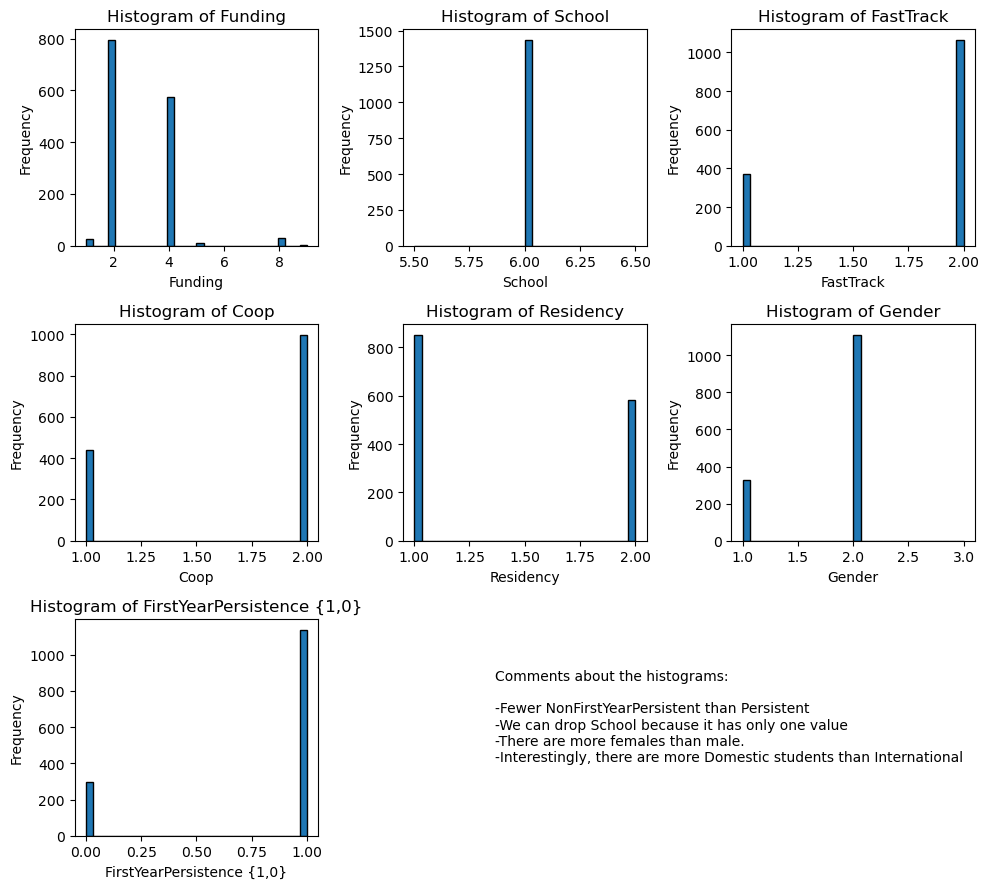

In [29]:
import matplotlib.pyplot as plt

# Get all numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
num_columns = len(numeric_columns)

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(10, 3 * ((num_columns // 3) + 1)))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each numeric column and create a histogram in a subplot
for i, column in enumerate(numeric_columns):
    axes[i].hist(df[column].dropna(), bins=30, edgecolor='black')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {column}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add comments about the plot
comment_text = (
    "Comments about the histograms:\n"
    "\n"
    "-Fewer NonFirstYearPersistent than Persistent\n"
    "-We can drop School because it has only one value\n"
    "-There are more females than male.\n"
    "-Interestingly, there are more Domestic students than International"
)
fig.text(0.5, 0.25, comment_text, ha='left', va='top', fontsize=10, wrap=True)

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()



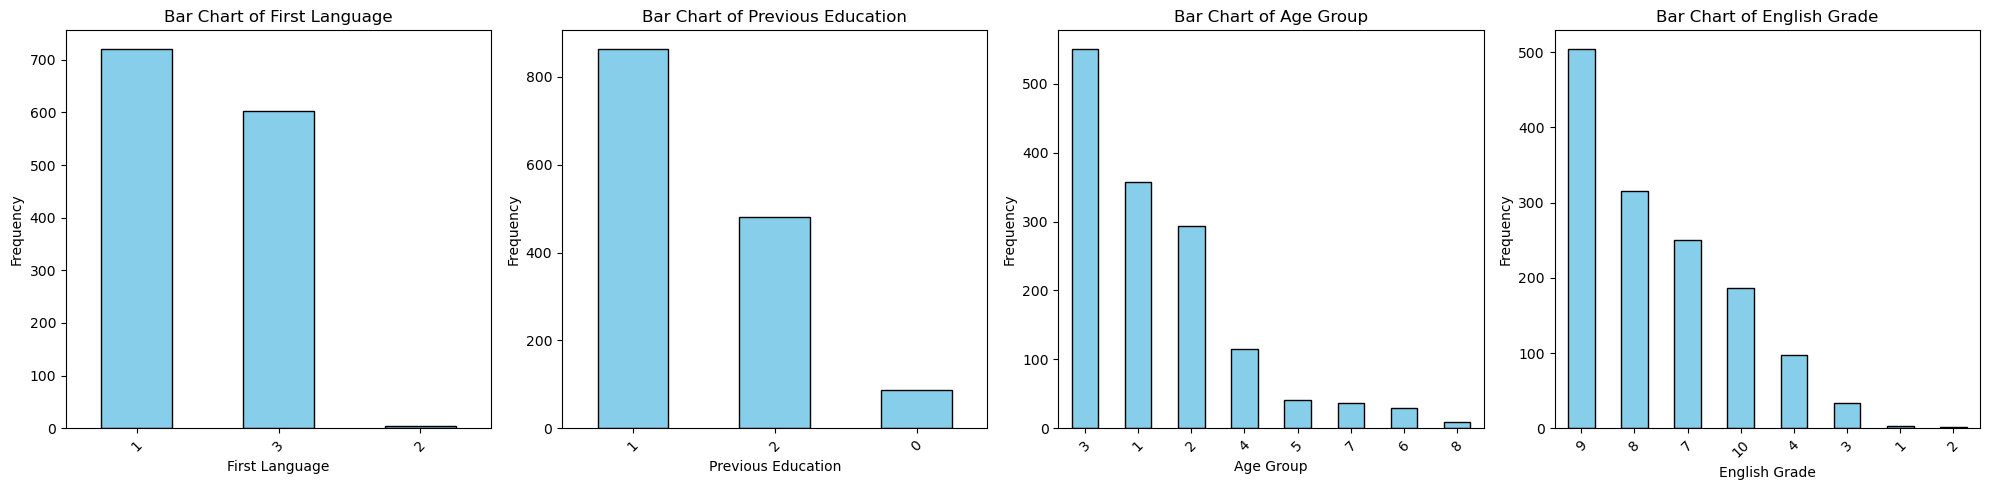

In [30]:



categorical_columns = ['First Language', 'Previous Education', 'Age Group', 'English Grade']
num_columns = len(categorical_columns)

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows =1, ncols=4, figsize=(20, 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each categorical column and create a bar chart in a subplot
for i, column in enumerate(categorical_columns):
    df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Bar Chart of {column}')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x labels if needed

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


In [31]:
import pandas as pd

# Identify duplicate rows
duplicates = df[df.duplicated(keep=False)]

# Display duplicate rows
print("Duplicate Rows: Must retain only one")
duplicates


Duplicate Rows: Must retain only one


,First Term Gpa,Second Term Gpa,First Language,Funding,School,FastTrack,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,"FirstYearPersistence {1,0}"
1022,0,NaN,3,4.0,6.0,1.0,2.0,2.0,2.0,1,3,NaN,NaN,8,0.0
1115,0,NaN,3,4.0,6.0,1.0,2.0,2.0,2.0,1,3,NaN,NaN,8,0.0


## Data Cleaning

### Drop Duplicates

In [32]:
#check for duplicated row
duplicates = df_cleaning.duplicated()
df_cleaning = df_cleaning.drop_duplicates()

#check for duplicated row
duplicates = df_cleaning.duplicated()
print(f'There are {duplicates.sum()} duplicated rows in the new dataset')


There are 0 duplicated rows in the new dataset


In [33]:
# Count the number of NaN values in each row
nan_counts = df_cleaning.isna().sum(axis=1)

# Find the maximum number of NaN values in any row
max_nan_count = nan_counts.max()

# Filter rows that have the maximum number of NaN values
rows_with_most_nans = df_cleaning[nan_counts == max_nan_count]

rows_with_most_nans


,First Term Gpa,Second Term Gpa,First Language,Funding,School,FastTrack,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,"FirstYearPersistence {1,0}"
539,0,NaN,NaN,4.0,6.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,10,0.0


### Check and convert Datatypes

In [34]:
df_cleaning.info()



#lets convert GPA,high school mark, Math score into float64

<class 'pandas.core.frame.DataFrame'>
Index: 1436 entries, 0 to 1436
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   First Term Gpa              1419 non-null   object 
 1   Second Term Gpa             1277 non-null   object 
 2   First Language              1325 non-null   object 
 3   Funding                     1436 non-null   float64
 4   School                      1436 non-null   float64
 5   FastTrack                   1436 non-null   float64
 6   Coop                        1436 non-null   float64
 7   Residency                   1436 non-null   float64
 8   Gender                      1436 non-null   float64
 9   Previous Education          1432 non-null   object 
 10  Age Group                   1432 non-null   object 
 11  High School Average Mark    694 non-null    object 
 12  Math Score                  975 non-null    object 
 13  English Grade               1391 non-n

In [35]:
float_columns = ['First Term Gpa','Second Term Gpa','High School Average Mark', 'Math Score']
object_columns = ['Funding','School', 'FastTrack', 'Coop', 'Residency', 'Gender']
for i in float_columns:
    df_cleaning[i] = df_cleaning[i].astype('float')

for i in object_columns:
    df_cleaning[i] = df_cleaning[i].astype('object')

### Drop irrelevant column ['School']

In [36]:
df_cleaning= df_cleaning.drop('School', axis = 1)

## Preprocessing

In [37]:
df_preprocessing = df_cleaning.copy()

In [38]:
X = df_preprocessing.drop(columns='FirstYearPersistence {1,0}')
y = df_preprocessing['FirstYearPersistence {1,0}']

In [39]:
#Split dataset


# Assuming X and y are your features and labels
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5, stratify=y_remain, random_state=42)

print(f'Shape of Training Dataset:{X_train.shape}, {y_train.shape}')
print(f'Shape of Testing Dataset:{X_test.shape}, {y_test.shape}')
print(f'Shape of Validation Dataset:{X_val.shape}, {y_val.shape}')


Shape of Training Dataset:(1005, 13), (1005,)
Shape of Testing Dataset:(216, 13), (216,)
Shape of Validation Dataset:(215, 13), (215,)


In [40]:
# Define columns for each transformation
median_col = ['Math Score', 'High School Average Mark']
mode_col = ['English Grade', 'Age Group']
fillwithzero_col = ['First Term Gpa', 'Second Term Gpa']
fillwith3_col = ['First Language']
passthrough_col = ['Funding', 'FastTrack', 'Coop', 'Residency', 'Gender', 'Previous Education']

median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', MinMaxScaler()) 
])

mode_pipeline = Pipeline(steps= [
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

custom0_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy = 'constant', fill_value=0.0)),
    ('scaler', MinMaxScaler())
])

custom3_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy = 'constant', fill_value=3.0)),
    ('scaler', MinMaxScaler())
])

passthrough_pipeline = Pipeline(steps= [
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('median', median_pipeline,median_col),
    ('mode', mode_pipeline,mode_col),
    ('custom0', custom0_pipeline,fillwithzero_col),
    ('custom3',custom3_pipeline,fillwith3_col ),
    ('passthrough', passthrough_pipeline, passthrough_col)
])

pipeline_prep = Pipeline(steps = [
    ('preprocessor', preprocessor)
])

In [42]:
X_train_transformed = pipeline_prep.fit_transform(X_train)
X_test_transformed = pipeline_prep.transform(X_test)
X_val_transformed = pipeline_prep.transform(X_val)

In [ ]:
import os
def convert_and_save_to_csv(data, pipeline, filename):
    # Combine all numerical columns
    numerical_columns = median_col + fillwithzero_col + fillwith3_col

    # Retrieve the column names generated by OneHotEncoder for mode and passthrough columns
    mode_encoded_columns = pipeline.named_steps['preprocessor'].named_transformers_['mode'].named_steps['onehot'].get_feature_names_out(mode_col)
    passthrough_encoded_columns = pipeline.named_steps['preprocessor'].named_transformers_['passthrough'].named_steps['onehot'].get_feature_names_out(passthrough_col)

    # Combine all column names
    all_columns = list(numerical_columns) + list(mode_encoded_columns) + list(passthrough_encoded_columns)

    # Convert the transformed data to a DataFrame
    data_df = pd.DataFrame(data, columns=all_columns)

    # Create the path to save the file in the "data" folder
    folder_path = "data"
    os.makedirs(folder_path, exist_ok=True)  # Create the folder if it does not exist
    file_path = os.path.join(folder_path, f"{filename}.csv")

    # Save the DataFrame to a CSV file in the "data" folder
    data_df.to_csv(file_path, index=False)
    print(f"Data saved to {file_path}")



In [44]:
convert_and_save_to_csv(X_train_transformed,pipeline_prep,'X_train_transformed' )
convert_and_save_to_csv(X_test_transformed,pipeline_prep,'X_test_transformed')
convert_and_save_to_csv(X_val_transformed,pipeline_prep,'X_val_transformed')

Data saved to data\X_train_transformed.csv


Data saved to data\X_test_transformed.csv
Data saved to data\X_val_transformed.csv
